In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageFont, ImageDraw
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/.dllist'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

In [4]:
trn_j = json.load((PATH/'pascal_train2007.json').open())

In [5]:
trn_j.keys(), len(trn_j)

(dict_keys(['images', 'type', 'annotations', 'categories']), 4)

In [6]:
trn_j

{'annotations': [{'area': 34104,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0,
   'image_id': 12,
   'iscrowd': 0,
   'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
  {'area': 13110,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]},
  {'area': 81326,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]]},
  {'area': 64227,
   'bbox': [8, 229, 237, 271],
   'category_id': 2,
   'id': 4,
   'ignore': 0,
   'image_id': 23,
   'iscrowd': 0,
   'segmentation': [[8, 229, 8, 500, 245, 500, 245, 229]]},
  {'area': 29505,
   'bbox': [229, 219, 105, 281],
   'category_id': 2,
   'id': 5,
   'ignore': 0,
   'image_id': 23,
   'iscrowd': 0,
   'segmentation': [[229, 219, 229, 500, 334, 500, 334, 219]]},
  

In [7]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[CATEGORIES][:5]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'}]

In [8]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [9]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [10]:
(PATH/'VOCdevkit'/'VOC2007').iterdir()

<generator object Path.iterdir at 0x7f02265c04c0>

In [11]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject')]

In [12]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [13]:
IMG_PATH = PATH/JPEGS

In [14]:
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000005.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000007.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000009.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000012.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000016.jpg')]

In [15]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

In [16]:
im3_d = trn_j[IMAGES][3]
im3_d[FILE_NAME], im3_d[ID]

('000026.jpg', 26)

In [17]:
def get_trn_anno():
    trn_anno = collections.defaultdict(list)
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            # bounding box is originally in the form [y_origin, x_origin, height, width]
            # we change it to [x_origin, y_origin, x_origin+width-1, y_origin+height-1]
            # proper co-ordinates of opposite corners of the bounding box
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

    return trn_anno

In [18]:
trn_anno = get_trn_anno()

In [19]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [20]:
im3_a = trn_anno[im3_d[ID]]; im3_a

[(array([124,  89, 211, 336]), 7)]

In [21]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [22]:
im_3a = im3_a[0]; im_3a

(array([124,  89, 211, 336]), 7)

In [23]:
cats[7]

'car'

In [24]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [25]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [26]:
cats[15], cats[13]

('person', 'horse')

In [27]:
# converts a bounding-box to height-width format, as opposed to jh's preferred width-height
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])

In [28]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [29]:
im3 = open_image(IMG_PATH/im3_d[FILE_NAME])

In [30]:
def show_image(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

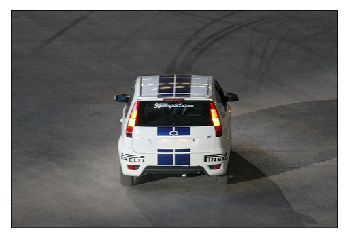

In [31]:
show_image(im)

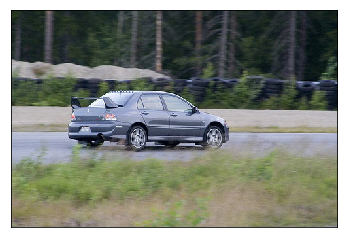

In [32]:
show_image(im3)

In [33]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, 
        foreground='black'), patheffects.Normal()])

In [34]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [35]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
                  verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

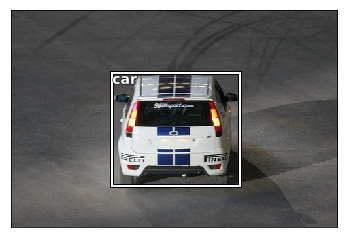

In [36]:
ax = show_image(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

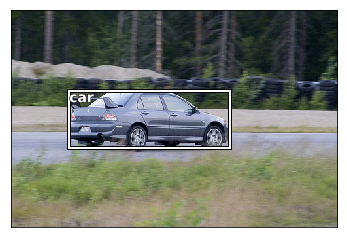

In [37]:
ax = show_image(im3)
b = bb_hw(im_3a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im_3a[1]])

In [38]:
def draw_im(im, ann):
    ax = show_image(im, figsize=(16, 8))
    for b, c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [39]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(375, 500, 3)


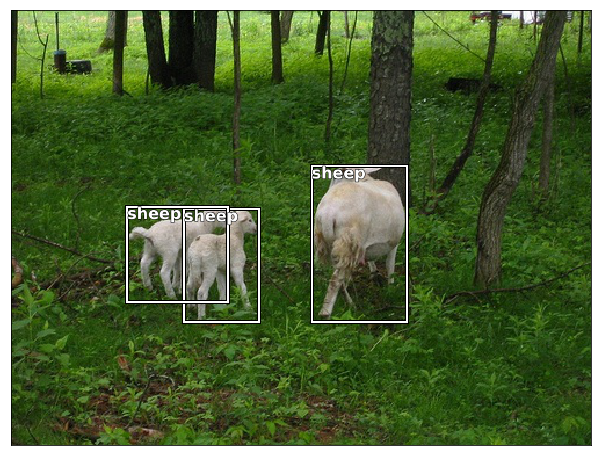

In [40]:
draw_idx(900)

In [41]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [42]:
trn_lrg_anno = {a: get_lrg(b) for a, b in trn_anno.items()}

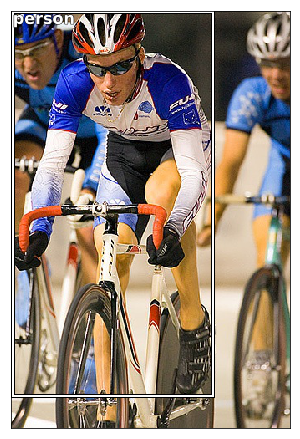

In [43]:
b, c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_image(open_image(IMG_PATH/trn_fns[23]), figsize=(5, 10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [44]:
(PATH/'tmp').mkdir(exist_ok=True)

In [45]:
CSV = PATH/'tmp/lrg.csv'

In [46]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                 columns=['fn', 'cat'])
df.to_csv(CSV, index=False)

In [47]:
df.head()

fn        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [48]:
f_model = resnext50
sz = 224
bs = 64

In [49]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


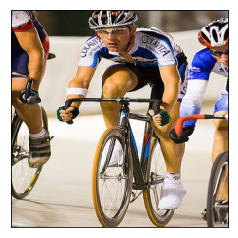

In [50]:
x, y = next(iter(md.val_dl))
show_image(md.val_ds.denorm(to_np(x))[0]);

In [51]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [52]:
lrf = learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:28<00:08,  1.15s/it, loss=13.4]

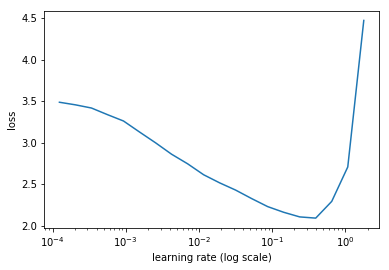

In [64]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [65]:
lr = 1e-1

In [66]:
learn.fit(lr, 1, cycle_len=2, cycle_mult=2, use_clr_beta=(10,13.68,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  3%|▎         | 1/32 [00:01<01:00,  1.95s/it, loss=3.58]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.57228    2.32722    0.698     
    1      1.657214   1.191598   0.794                    



[array([1.1916]), 0.7939999980926513]

In [67]:
lrs = np.array([lr/1000, lr/100, lr])

In [68]:
learn.freeze_to(-2)

In [69]:
rf = learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:23<00:04,  1.14it/s, loss=8.9] 

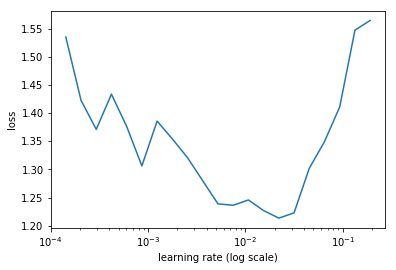

In [70]:
learn.sched.plot(1)

In [76]:
learn.fit(lrs/5, 3, cycle_len=3, use_clr_beta=(10,13.68,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=9), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.659311   0.993347   0.82      
    1      0.595402   1.058901   0.804                     
    2      0.44743    0.921938   0.812                     
    3      0.284497   0.871439   0.814                     
    4      0.249285   1.215581   0.774                     
    5      0.204753   0.982627   0.802                     
    6      0.145069   0.954082   0.82                      
    7      0.147153   1.113052   0.808                     
    8      0.147159   1.024553   0.82                      



[array([1.02455]), 0.8199999980926513]

In [77]:
learn.save('class_one')

In [ ]:
learn.load('class_one')

In [78]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), 1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


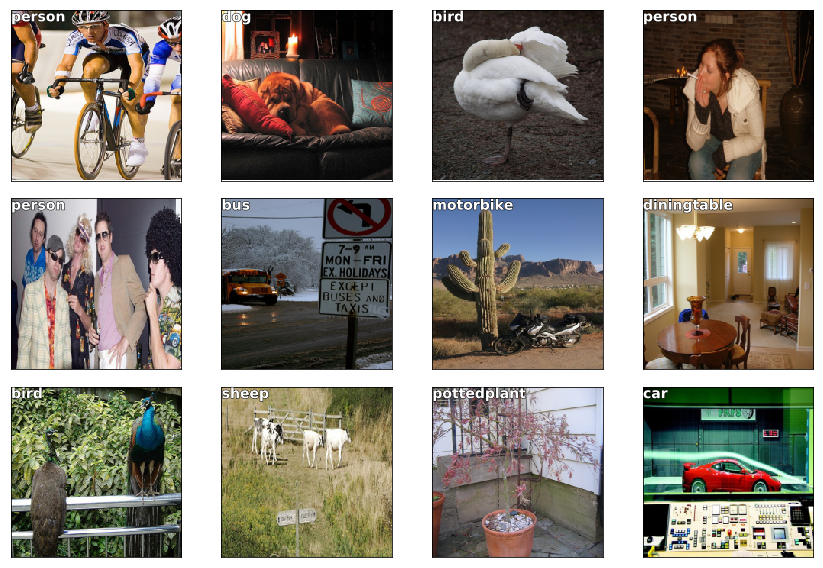

In [79]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_image(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()

In [80]:
BB_CSV = PATH/'tmp/bb.csv'

In [81]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [82]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [83]:
f_model = resnet34
sz = 224
bs = 64

In [84]:
# four numbers: top left (x and y), bottom right (x and y)
# create a neural net with four activations (no softmax or sigmoid)
# use a mean-squared error loss-function
# our loss function should be such that its value being lower, means our four numbers are better

In [85]:
# custom aug transforms
tfm_y = TfmType.COORD
augs = [
    RandomFlip(tfm_y=tfm_y),
    RandomRotate(3, p=0.5, tfm_y=tfm_y),
    RandomLighting(0.05, 0.05, tfm_y=tfm_y)
]

In [86]:
tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [87]:
x, y = next(iter(md.val_dl))

In [88]:
ima = md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


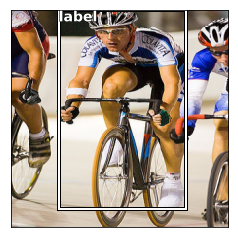

In [89]:
ax = show_image(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [90]:
# custom heads can be added to your convnet (fastai feature)
# instead of the adaptive pooling and fully connected net, which are added by default. 
# No pooling needed, since we need to know the activation of each grid cell
# We get 4 activations, one per bbox coordinate. Our target is continuous, so the 
# MSE loss does not need softmax or sigmoid activations applied on the output 

In [91]:
# Matching the output of the previous Conv2d layer, which outputs a 512*7*7 tensor, we flatten
# the custom head.
512 * 7 * 7

25088

In [92]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
# rather than add up the squared errors, add up the absolute values of the errors, i.e. don't penalize bad misses by too much
learn.crit = nn.L1Loss()

In [93]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [94]:
learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 24/32 [00:12<00:04,  1.98it/s, loss=396] 

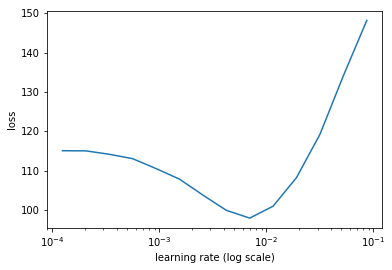

In [95]:
learn.sched.plot(5)

In [96]:
lr = 2e-3

In [97]:
learn.fit(lr, 2, cycle_len=2, cycle_mult=2, use_clr_beta=(10,13.68,0.95,0.85), wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                   


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      51.993375  31.212742 
    1      37.145584  28.925884                           
    2      31.962165  27.841996                           
    3      28.768717  26.683352                           
    4      27.005003  26.661121                           
    5      25.527981  26.004076                           



[array([26.00408])]

In [98]:
lrs = np.array([lr/1000, lr/100, lr])

In [99]:
learn.freeze_to(-3)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:29<00:03,  1.00s/it, loss=103] 

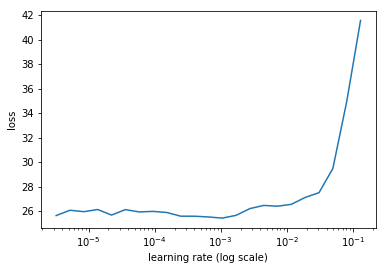

In [100]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [101]:
learn.fit(lrs, 2, cycle_len=2, cycle_mult=2, use_clr_beta=(10,13.68,0.95,0.85), wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

 16%|█▌        | 5/32 [00:07<00:40,  1.49s/it, loss=24.3]


Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      24.218267  27.153895 
    1      22.837782  24.224206                           
    2      21.392969  24.339856                           
    3      20.180115  22.727017                           
    4      19.327123  23.399703                           
    5      18.357055  22.590053                           



[array([22.59005])]

In [102]:
learn.save('reg4')

In [ ]:
learn.load('reg4')

In [103]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


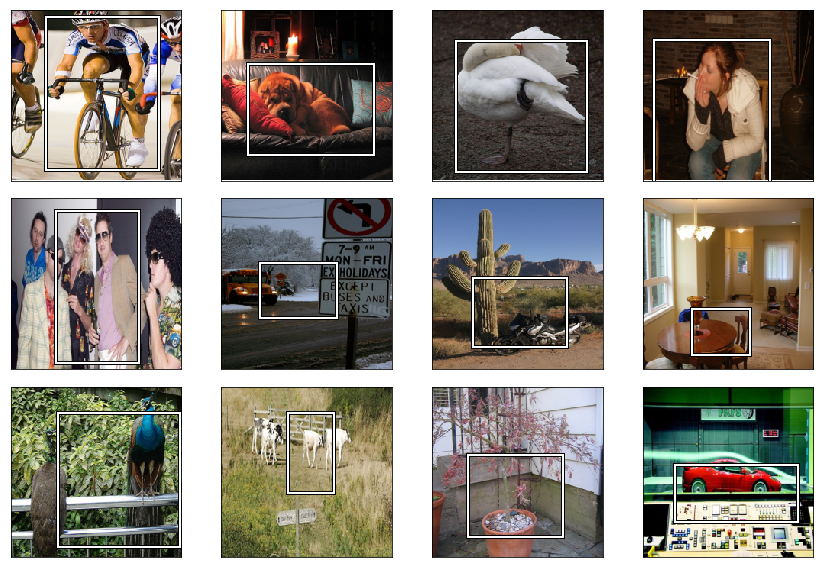

In [104]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_image(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

In [105]:
# Single object detection

In [125]:
f_model = resnet50
sz = 224
bs = 64

val_idxs = get_cv_idxs(len(trn_fns))

In [126]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, val_idxs=val_idxs)

In [127]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [128]:
# dataset can be anything with __len__ and __getitem__
class ConcatLabelDataset(Dataset):
    """This dataset has, as independent variable, a set of images. 
    As dependent variable, it has a tuple whose first element is the 
    bounding box, the second element being the class of the object
    """
    def __init__(self, ds, y2): self.ds, self.y2 = ds, y2
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        """
        Grab an x and y from the dataset, and return a tuple containing that x 
        as the first element, with second element as a tuple of the y, and the 
        ith element of the second dependent variable
        """
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [129]:
# add classes to the bounding box labels
trn_ds2 = ConcatLabelDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLabelDataset(md.val_ds, md2.val_y)

In [130]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [131]:
# replace the md dataset with the new one

In [132]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [ ]:
x, y = next(iter(md.val_dl))
idx = 65
ima = md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

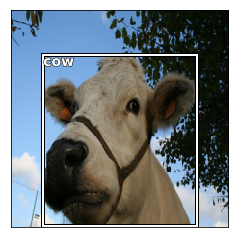

In [115]:
ax = show_image(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [116]:
# one output activation from each class (probability), plus one for each bounding box coordinate
# extra linear layer, and some dropout, gives us a more flexible model.

In [121]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + len(cats))
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [122]:
def detn_loss(input, target):
    bb_t, c_t = target
    bb_i, c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # multiplier of cross_entropy experimentally determined to be 20, 
    # such that the elements of the sum are roughly equal, thus preventing one
    # ffrom dominating the other
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * 20

def detn_l1(input, target):
    bb_t, _ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i) * 224
    return F.l1_loss(V(bb_i), V(bb_t)).data

def detn_acc(input, target):
    _, c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

In [123]:
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [124]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: size mismatch at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorMathBlas.cu:247

In [ ]:
learn.sched.plot(1)

In [169]:
lr = 1e-3

In [170]:
learn.fit(lr, 2, cycle_len=3, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

 56%|█████▋    | 18/32 [00:06<00:05,  2.62it/s, loss=112]

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1      
    0      100.351527 83.68869   0.80018    65.78276  
    1      83.435687  63.135559  0.822115   46.868234     
    2      72.503844  58.872234  0.81866    43.087687     
    3      63.535398  47.513042  0.828425   33.492586     
    4      53.055247  39.136749  0.82497    26.285109     
    5      45.256859  37.547665  0.827374   24.789879     



[37.547665, 0.8273737952113152, 24.789879322052002]

In [171]:
learn.save('reg1_0')

In [ ]:
learn.load('reg1_0')

In [173]:
learn.freeze_to(-2)

In [174]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:17<00:01,  1.68it/s, loss=337] 

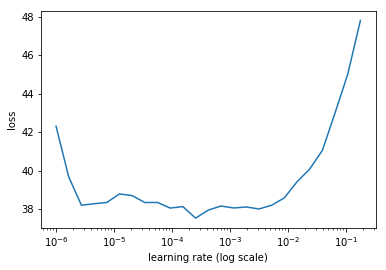

In [175]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [176]:
learn.fit(lrs/5, 3, cycle_len=5, cycle_mult=2, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=35), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                   


Exception in thread Thread-35:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      38.006897  37.763424  0.820613   25.330528 
    1      35.484828  35.482712  0.828425   23.603035     
    2      33.571714  34.323013  0.834285   22.863318     
    3      31.612858  34.04285   0.836689   22.614742     
    4      30.274034  33.819527  0.840595   22.512061     
    5      29.106917  33.762886  0.834285   22.491699     
    6      28.234614  33.962784  0.829928   22.673524     
    7      27.355997  33.557251  0.842097   22.466316     
    8      26.514058  32.646824  0.84991    21.887216     
    9      25.70538   32.488003  0.847957   21.743086     
    10     25.107819  32.635193  0.835787   21.853206     
    11     24.507832  32.282127  0.846004   21.62271      
    12     23.747176  32.006172  0.846004   21.262754     
    13     22.987182  32.140999  0.836238   21.260343     
    14     22.342802  32.100388  0.832332   21.245347     
    15     22.11539   32.101624  0.841647   21.230934     
 

[30.580343, 0.843599759042263, 20.274773836135864]

In [177]:
learn.save('reg1_1')

In [ ]:
learn.load('reg1_1')

In [178]:
learn.unfreeze()

In [179]:
learn.fit(lrs/10, 1, cycle_len=10, cycle_mult=2, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.887383  30.804964  0.846454   20.311914 
    1      15.494625  30.742167  0.841647   20.183701     
    2      15.390414  30.595993  0.841196   20.137945     
    3      15.321069  30.73558   0.839243   20.12591      
    4      15.165019  30.517975  0.841196   20.008784     
    5      14.843162  30.463913  0.846004   19.915106     
    6      14.821345  30.505377  0.845553   19.9164       
    7      14.672384  30.48518   0.839694   19.930231     
    8      14.409076  30.456039  0.83774    19.948673     
    9      14.353202  30.505762  0.835337   19.934816     



[30.505762, 0.8353365361690521, 19.934816360473633]

In [185]:
learn.fit(lrs/100, 1, cycle_len=10, cycle_mult=3, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      14.053541  30.306801  0.8436     19.864726 
    1      14.177034  30.452881  0.835337   19.913877     
    2      14.059641  30.477558  0.831881   19.874283     
    3      13.981362  30.387016  0.839243   19.938613     
    4      14.01874   30.44232   0.841647   19.943012     
    5      14.093762  30.377916  0.83774    19.868535     
    6      14.070569  30.41275   0.839694   19.897252     
    7      14.107559  30.446505  0.841647   19.879437     
    8      14.014789  30.355963  0.841647   19.860124     
    9      13.937603  30.562103  0.8436     19.886655     



[30.562103, 0.843599759042263, 19.88665509223938]

In [186]:
y = learn.predict()
x, _ = next(iter(md.val_dl))

In [187]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


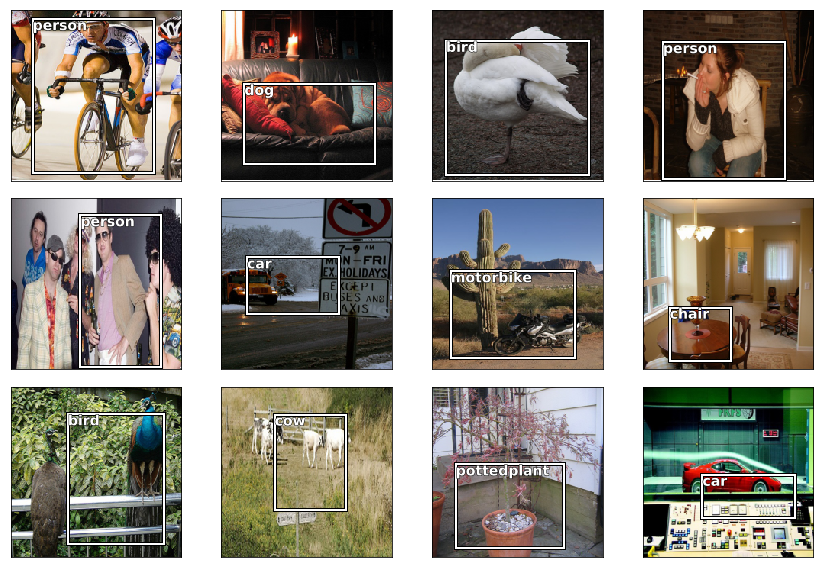

In [188]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_image(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()